# RcTorch 2021 NuerIPS submission Notebook 2
## Backpropagation solutions: 1st order  nonlinear Bernoulli Equation

In [1]:
cd /Users/hayden/Desktop/RcTorchAsIs

/Users/hayden/Desktop/RcTorchAsIs


In [2]:
!./cp_rctorchprivate.sh

In [5]:
import ray
#ray.init(num_cpus = 8)

#import packages
import numpy as np
from numpy import loadtxt
import pylab as pl
from IPython import display
#from RcTorch import *
from rctorchprivate import *
from matplotlib import pyplot as plt
from scipy.integrate import odeint
import time
import matplotlib.gridspec as gridspec

#this method will ensure that the notebook can use multiprocessing (train multiple 
#RC's in parallel) on jupyterhub or any other linux based system.
try:
    mp.set_start_method("spawn")
except:
    pass
torch.set_default_tensor_type(torch.FloatTensor)
%matplotlib inline
start_time = time.time()

In [6]:
# ! pip install rctorch==0.7162

In [7]:
start_time = time.time()

In [8]:
lineW = 3
lineBoxW=2

font = {'size'   : 24}

plt.rc('font', **font)
plt.rcParams['text.usetex'] = True

### This notebook contains the solutions to the Bernoulli type nonlinear equations of the form 
\begin{align}
    \label{eq:bernoulli}
    a_1(t) \dot y + a_0(t) y + q(t) y^2 = f(t).
\end{align}

While we cannot solve this equation exactly, we do have a linearized approximation that we can use to speed up the approximation method. We will refer to this method as a hybrid linearization-backprop method.

With RC we only optimize the last layer (the output layer). In the case of  a linear differential equation, we can solve this exactly. In the nonlinear case we can drop the nonlinear term and thereby get a linear approximation, but this won't get us all the way to the bottom of the loss function. Thus, we need to use gradient descent which is fast because we only optimize one layer. The hybrid method initializes the weights to the linearization, which is shown below to find better solutions that the backprop only method (random weight initialization).
A comparison of hybrid vs backprop is shown below (credit to Shivam Raval). The idea is that the hybrid method is indeed faster for finding solutions of the same quality. That is, we observe faster descent and lower minima when initializing to the linearized approximation. Somehow we jump to a convex part of the loss function.

In [9]:
def driven_force(X, A = 1):
    """ a force function, specifically f(t) = sin(t)
    Parameters
    ----------
    X: torch.tensor
        the input time tensor
    
    Returns
    -------
    the force, a torch.tensor of equal dimension to the input time tensor.
    """
    return A * torch.sin(X)

def no_force(X, A = 0):
    """ a force function (returns 0)
    
    Parameters
    ----------
    X: torch.tensor
        the input time tensor
    
    Returns
    -------
    the force, in this case 0.
    """
    return torch.zeros_like(X)

q = 0.5
def custom_loss(X , y, ydot, out_weights, force_t = no_force, 
                reg = True, ode_coefs = None, q = q, 
                init_conds = None, enet_strength = None, enet_alpha = None,
                mean = True):
    """ The loss function of the ODE (in this case the bernoulli equation loss)
    Parameters
    ----------
    X: torch.tensor
        The input (in the case of ODEs this is time t)
    y: torch.tensor
        The response variable
    ydot: torch.tensor
        The time derivative of the response variable
    enet_strength: float
        the magnitude of the elastic net regularization parameter. In this case there is no e-net regularization
    enet_alpha: float
        the proportion of the loss that is L2 regularization (ridge). 1-alpha is the L1 proportion (lasso).
    ode_coefs: list
        this list represents the ODE coefficients. They can be numbers or t**n where n is some real number.
    force: function
        this function needs to take the input time tensor and return a new tensor f(t)
    reg: bool
        if applicable (not in the case below) this will toggle the elastic net regularization on and off
    reparam: function
        a reparameterization function which needs to take in the time tensor and return g and gdot, which 
        is the reparameterized time function that satisfies the initial conditions.
    init_conds: list
        the initial conditions of the ODE.
    mean: bool
        if true return the cost (0 dimensional float tensor) else return the residuals (1 dimensional tensor)
    q: float
        a bernoulli specific hyper-parameter
        
    Returns
    -------
    the residuals or the cost depending on the mean argument (see above)
    """
    #with paramization
    L =  ydot + ode_coefs[0]* y - force_t + q*y**2
    
    L = torch.square(L)
    if mean:
         L = torch.mean(L)
    return L

In [10]:
def plot_predictions(RC, results, integrator_model, y0s = None,  ax = None):
    """plots a RC prediction and integrator model prediction for comparison
    Parameters
    ----------
    RC: RcTorchPrivate.esn
        the RcTorch echostate network to evaluate. This model should already have been fit.
    results: dictionary
        the dictionary of results returned by the RC after fitting
    integrator model: function
        the model to be passed to odeint which is a gold standard integrator numerical method
        for solving ODE's written in Fortran. You may find the documentation here:
        https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html
    ax: matplotlib.axes._subplots.AxesSubplot
        If provided, the function will plot on this subplot axes
    """
    X = process(RC.X)
    if not ax:
        fig, ax = plt.subplots(1,1, figsize = (6,6))
    for i, y in enumerate(results["ys"]):
        y = process(y)
        if not i:
            labels = ["RC", "Integrator Solution"]
        else:
            labels = [None, None]
        ax.plot(X, y, label = labels[0], linewidth = lineW + 2, alpha = 0.9)

        #calculate the integrator prediction:
        int_sol = odeint(integrator_model, y0s[i], np.array(X.cpu().squeeze()))
        int_sol = torch.tensor(int_sol)
        
        #plot the integrator prediction
        ax.plot(X, int_sol, '--', color = "black", alpha = 0.95, label = labels[1],  linewidth = lineW - 1)
    
    plt.ylabel(r'$y(t)$');
    ax.legend();
    ax.tick_params(labelbottom=False)
    plt.tight_layout()

def plot_results(RC, results, integrator_model, y0s = None, ax = None):
    """plots a RC prediction and integrator model prediction for comparison
    Parameters
    ----------
    RC: RcTorchPrivate.esn
        the RcTorch echostate network to evaluate. This model should already have been fit.
    results: dictionary
        the dictionary of results returned by the RC after fitting
    integrator model: function
        the model to be passed to odeint which is a gold standard integrator numerical method
        for solving ODE's written in Fortran. You may find the documentation here:
        https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html
    ax: matplotlib.axes._subplots.AxesSubplot
        If provided, the function will plot on this subplot axes
    """
    X = RC.X.detach()
    
    #int_sols = []
    if not ax:
        fig, ax = plt.subplots(1,1, figsize = (6,6))
    for i, y in enumerate(results["ys"]):
        if not i:
            labels = ["RC", "integrator solution"]
        else:
            labels = [None, None]
        y = y.detach()
        ax.plot(X, y, color = "blue", label = labels[0])

        #calculate the integrator prediction:
        int_sol = odeint(integrator_model, y0s[i], np.array(X.cpu().squeeze()))
        int_sol = torch.tensor(int_sol)
        #int_sols.append(int_sol)
        
        #plot the integrator prediction
        ax.plot(X, int_sol, '--', color = "red", alpha = 0.9, label = labels[1])
        
    ax.set_xlabel("time")
    ax.set_ylabel("y")
    ax.legend();
    #return int_sols
        
def process(tensor_):
    """ takes a tensor and prepares it for plotting.
    """
    return tensor_.cpu().detach()
        
def plot_rmsr(RC, results, force, ax = None):
    """plots the residuals of a RC prediction directly from the loss function
    Parameters
    ----------
    RC: RcTorchPrivate.esn
        the RcTorch echostate network to evaluate. This model should already have been fit.
    results: dictionary
        the dictionary of results returned by the RC after fitting
    force: function
        the force function describing the force term in the population equation
    ax: matplotlib.axes._subplots.AxesSubplot
        If provided, the function will plot on this subplot axes
    """
    if not ax:
        fig, ax = plt.subplots(1,1, figsize = (10, 4))
    X = process(RC.X)
    ys, ydots = results["ys"], results["ydots"]
    
    residuals = []
    force_t = force(X)
    for i, y in enumerate(ys):
        ydot = ydots[i]
        y = process(y)
        ydot = process(ydot)
        
        ode_coefs = covert_ode_coefs(t = X, ode_coefs = RC.ode_coefs)
        
        resids = custom_loss(X, y, ydot, None, 
                             force_t = force_t, 
                             ode_coefs = RC.ode_coefs,
                             mean = False)
        if not i:
            resids_tensor = resids
        else:
            resids_tensor = torch.cat((resids_tensor, resids), axis = 1)
        resids_specific_rmsr = torch.sqrt(resids/1) 
            
        ax.plot(X, resids_specific_rmsr, alpha = 0.7, linewidth = lineW -1)
        residuals.append(resids)
    
    mean_resid = torch.mean(resids_tensor, axis =1)
    rmsr = torch.sqrt(mean_resid)
#     ax.plot(X, rmsr, 
#                color = "blue", 
#                alpha = 0.9, 
#                label = r'{RMSR}')

    #ax.legend(prop={"size":16});
    
    ax.set_xlabel(r'$t$')
    ax.set_yscale("log")
    ax.set_ylabel(r'{RMSR}')

def covert_ode_coefs(t, ode_coefs):
    """ converts coefficients from the string 't**n' or 't^n' where n is any float
    Parameters
    ----------
    t: torch.tensor
        input time tensor
    ode_coefs: list
        list of associated floats. List items can either be (int/floats) or ('t**n'/'t^n')
    """
    type_t = type(t)
    for i, coef in enumerate(ode_coefs):
        if type(coef) == str:
            if coef[0] == "t" and (coef[1] == "*" or (coef[1] == "*" and coef[2] == "*")):
                pow_ = float(re.sub("[^0-9.-]+", "", coef))
                ode_coefs[i]  = t ** pow_
                print("alterning ode_coefs")
        elif type(coef) in [float, int, type_t]:
            pass
        else:
            assert False, "ode_coefs must be a list floats or strings of the form 't^pow', where pow is a real number."
    return ode_coefs
    

#define a reparameterization function, empirically we find that g= 1-e^(-t) works well)
def reparam(t, order = 1):
    """ A reparameterization function, specifically g= 1-e^(-t)
    
    Arguments:
    t: torch.tensor
        the input time tensor
    order:
        the ODE order
    
    Returns:
    g: torch.tensor
        the reparameterization of t which satisfies the initial conditions
    g_dot: torch.tensor
        the time derivative of g
    """
    
    exp_t = torch.exp(-t)
    derivatives_of_g = []
    
    g = 1 - exp_t
    g_dot = 1 - g
    return g, g_dot

In [11]:
def optimize_last_layer(esn, 
                        SAVE_AFTER_EPOCHS = 1,
                        epochs = None,#30000,
                        custom_loss = custom_loss,
                        force = no_force,
                        learning_rate = 0.01,
                        plott = False,
                        spikethreshold = 0.25,
                        force_t = None,
                        plot_every_n_epochs = 1500):
    """ The backprop function for the output layer of the RC
    
    Parameters
    ----------
    esn: EchoStateNetwork object
        a pretrained echostate network
    SAVE_AFTER_EPOCHS: int
        after this amount of epochs the function will start saving the best score and predictions
    epochs: int
        epochs of backpropagation to complete
    custom_loss: function
        the loss function
    force: function
        the force function
    force_t: tensor
        the force function applied to X (for speed)
    learning_rate: float
        the starting learning rate (0.1 or 0.01 recommended)
    plott: bool
        if true, the backpropogation will plot interactively
    spikethreshold: float
        if the loss increases by more than this amount, the learning rate will slow down.
    plot_every_n_epochs: int
        how often to plot the loss 
    Returns
    -------
    a dict of the best_score, best weight (and bias), best prediction (and associated derivative), loss history, 
    """
    #assert False
    with torch.enable_grad():
        #define new_x
        new_X = esn.extended_states.detach()

        #force detach states_dot
        esn.states_dot = esn.states_dot.detach().requires_grad_(False)

        #define criterion
        criterion = torch.nn.MSELoss()

        try:
            assert esn.LinOut.weight.requires_grad and esn.LinOut.bias.requires_grad
        except:
            esn.LinOut.weight.requires_grad_(True)
            esn.LinOut.bias.requires_grad_(True)
        #define previous_loss (could be used to do a convergence stop)
        previous_loss = 0

        #define best score so that we can save the best weights
        best_score = None

        #define the optimizer
        optimizer = optim.Adam(esn.parameters(), lr = learning_rate)

        #define the loss history
        loss_history = []

        if plott:
            #use pl for live plotting
            fig, ax = pl.subplots(1,3, figsize = (16,4))

        t = esn.X#.view(*N.shape).detach()
        g, g_dot = esn.G
        y0  = esn.init_conds[0]

        #optimizer = torch.optim.SGD(model.parameters(), lr=100)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)
        lrs = []

        floss_last = 0
        if type(force_t) != type(None):
            force_t = force(t)
        #begin optimization loop
        for e in range(epochs):

            optimizer.zero_grad()

            N = esn.forward( esn.extended_states )
            N_dot = esn._calc_Ndot(esn.states_dot)

            y = y0  + g *N 

            ydot = g_dot * N + g * N_dot

            assert N.shape == N_dot.shape, f'{N.shape} != {N_dot.shape}'

            assert esn.LinOut.weight.requires_grad and esn.LinOut.bias.requires_grad

            total_ws = esn.LinOut.weight.shape[0] + 1
            weight_size_sq = torch.mean(torch.square(esn.LinOut.weight))

            loss = custom_loss(esn.X, y, ydot, esn.LinOut.weight, force_t = force_t, reg = False, ode_coefs = esn.ode_coefs)
            loss.backward()
            optimizer.step()
            floss = float(loss)
            

            if not e and not best_score:
                best_bias, best_weight = esn.LinOut.bias.detach(), esn.LinOut.weight.detach()

            if e > SAVE_AFTER_EPOCHS:
                if not best_score:
                    best_score = min(loss_history)
                if floss <= min(loss_history):
                    best_bias, best_weight = esn.LinOut.bias.detach(), esn.LinOut.weight.detach()
                    best_score = float(loss)
                    best_pred = y.clone()
                    best_ydot = ydot.clone()
            
            if e > 1:
                #if the function spikes (starts to move away from the convex area)
                #lower the lr.
                if float(np.log(floss_last) - np.log(floss)) > spikethreshold:
                    lrs.append(optimizer.param_groups[0]["lr"])
                    scheduler.step()
                    #for param_group in optimizer.param_groups:
                    #    print('lr', param_group['lr'])
            floss_last = floss
            loss_history.append(floss)
            if plott:

                if e % plot_every_n_epochs == 0:
                    ax[0].clear()
                    logloss_str = 'Log(L) ' + '%.2E' % Decimal((loss).item())
                    delta_loss  = ' delta Log(L) ' + '%.2E' % Decimal((loss-previous_loss).item())

                    print(logloss_str + ", " + delta_loss)
                    ax[0].plot(y.detach().cpu(), label = "exact")
                    ax[0].set_title(f"Epoch {e}" + ", " + logloss_str)
                    ax[0].set_xlabel("epochs")

                    ax[1].set_title(delta_loss)
                    ax[1].plot(y_dot.detach().cpu())

                    ax[2].clear()
                    weight_size = str(weight_size_sq.detach().item())
                    ax[2].set_title("loss history \n and "+ weight_size)

                    ax[2].loglog(loss_history)
                    
                    ax[0].legend()
                    previous_loss = loss.item()

                    #clear the plot outputt and then re-plot
                    display.clear_output(wait=True) 
                    display.display(pl.gcf())
        backprop_args = {"loss_history" : loss_history, 
                             "lr" : learning_rate,
                             "epochs" : epochs
                            }
        return {"weights": best_weight, 
                "bias" : best_bias, 
                "loss" : backprop_args,
                "ydot" : best_ydot, 
                "y" : best_pred,
                "best_score" : best_score}
        

In [12]:
BURN_IN = 1000
x0,xf, nsteps = 0, 5, 1000
xtrain = torch.linspace(x0, xf, steps = nsteps, requires_grad=False)

#the length of xtrain won't matter above. Only dt , x0, and xf matter for ODEs.
#the reason for this is that the input time vector is reconstructed internally in rctorch
#in order to satisfy the specified dt.
xtrain = torch.linspace(x0, xf, steps = nsteps, requires_grad=False).view(-1,1)

In [13]:

hybrid_hps_q05 = {'dt': 0.007943282347242814,
 'n_nodes': 500,
 'connectivity': 0.0003179179463749722,
 'spectral_radius': 7.975825786590576,
 'regularization': 0.3332787303378571,
 'leaking_rate': 0.07119506597518921,
 'bias': -0.9424528479576111}

In [14]:
dRay=0.75
y0s = np.arange(-1., 1 + dRay, dRay)

train_args = {"burn_in" : int(BURN_IN), 
              "ODE_order" : 1,
              "force" : no_force,
              "reparam_f" : reparam,
              "init_conditions" : [y0s],
              "ode_coefs" : [1, 1],
              "X" : xtrain.view(-1,1),
              "q" : q,
              "nl" : True,
              }

### Linear approximation of Bernoulli equation (no backprop):

In [15]:
%%time

RC = RcNetwork(**hybrid_hps_q05,
                      random_state = 209, 
                      dtype = torch.float32)



results = RC.fit(backprop_f = None,#optimize_last_layer,
                 train_score = True, 
                 ODE_criterion = custom_loss,
                 SOLVE = True,
                 **train_args)

Loaded Reservoir is Nilpotent (max_eigenvalue =0.0), connectivity =0.00031792.. .regenerating
1 2 3 4 5 6 7 8 CPU times: user 282 ms, sys: 134 ms, total: 415 ms
Wall time: 395 ms


In [16]:
def Bernoulli_model(y,t, q = q):
    k = 1
    dydt = -k * y -q*y**2
    return dydt

In [17]:
y0s

array([-1.  , -0.25,  0.5 ,  1.25])

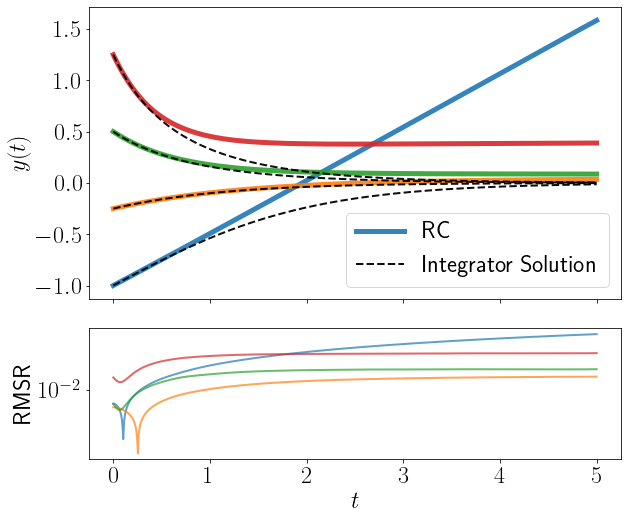

In [18]:
#show results:
fig = plt.figure(figsize = (9,7)); gs1 = gridspec.GridSpec(3, 3);
ax = plt.subplot(gs1[:-1, :])

plot_predictions(RC, results, Bernoulli_model, y0s, ax = ax)

ax = plt.subplot(gs1[-1, :])
plot_data = plot_rmsr(RC, 
                      results, 
                      force = no_force, 
                      ax = ax)

### Backprop Only Method (output weights randomly initialized)

In [19]:
EPOCHS = 50000

In [20]:
backprop_args = {"SAVE_AFTER_EPOCHS" : 1,
                 "epochs" : None,#30000,
                 "custom_loss" : custom_loss,
                 "force" : no_force,
                 "lr" : 0.01, #learning_rate
                 "plott" : False,
                 "spikethreshold" : 0.25,
                 "force_t" : None,
                 "plot_every_n_epochs" : 1500}

In [21]:
%%time
RC = RcNetwork(**hybrid_hps_q05,
                      random_state = 209, 
                      dtype = torch.float32)

backprop_results = RC.fit( backprop_f = optimize_last_layer,
                           train_score = True, 
                           ODE_criterion = custom_loss,
                           SOLVE = False,
                           **train_args,
                           #spikethreshold = 0.25,
                           backprop_args = backprop_args,
                           epochs = EPOCHS)

Loaded Reservoir is Nilpotent (max_eigenvalue =0.0), connectivity =0.00031792.. .regenerating
1 2 3 4 5 6 7 8 CPU times: user 1min 50s, sys: 774 ms, total: 1min 50s
Wall time: 1min 51s


In [22]:
def loss_plot(losses):
    for loss_hist in losses:
        plt.loglog(loss_hist, linewidth = lineW)
        plt.xlabel("epochs")
        plt.ylabel("RMSR")

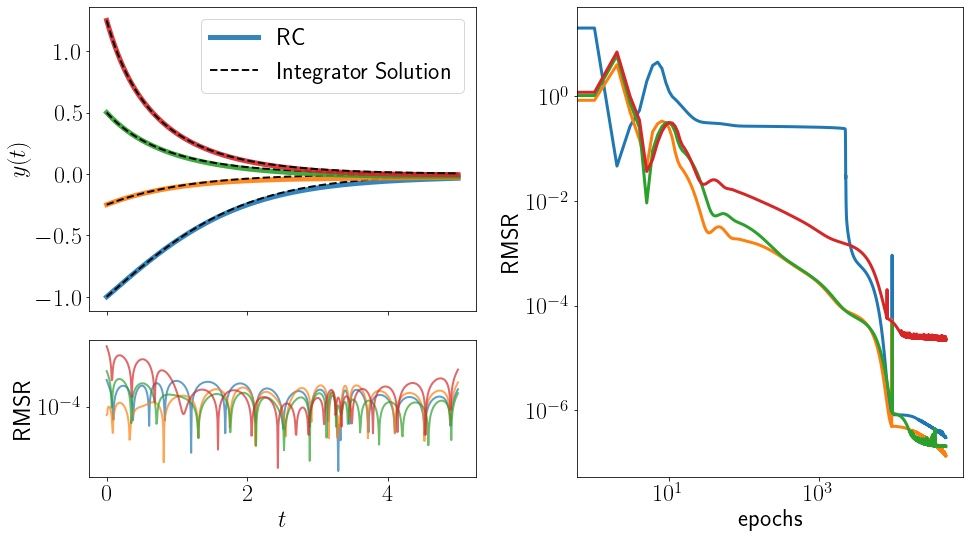

In [23]:
#show results:
fig = plt.figure(figsize = (14,8)); gs1 = gridspec.GridSpec(3, 3);
gs1 = gridspec.GridSpec(3, 6)
horiz_boundary = -3
vert_boundary = -1
g1, g2, g3 = gs1[:vert_boundary, :horiz_boundary], gs1[vert_boundary, :horiz_boundary], gs1[:, horiz_boundary:]
ax=plt.subplot(g1)
plot_predictions(RC, backprop_results, Bernoulli_model, y0s, ax = ax)

ax=plt.subplot(g2)
plot_data = plot_rmsr(RC, 
                      backprop_results, 
                      force = no_force, 
                      ax = ax)
plt.subplot(g3)
loss_plot(backprop_results["losses"])
plt.tight_layout()

### Hybrid Method: Linearization and backpropagation combined.

Here we initialize the weights for gradient descent to the linearized approximation, which improves the quality of the solutions we get from backpropagation.

In [24]:
RC.epochs

50000

In [25]:
%%time
hybrid_results = RC.fit(backprop_f = optimize_last_layer,
                        train_score = True, 
                        ODE_criterion = custom_loss,
                        SOLVE = True,
                        **train_args,
                        epochs = EPOCHS)

CPU times: user 2min 1s, sys: 591 ms, total: 2min 2s
Wall time: 2min 6s


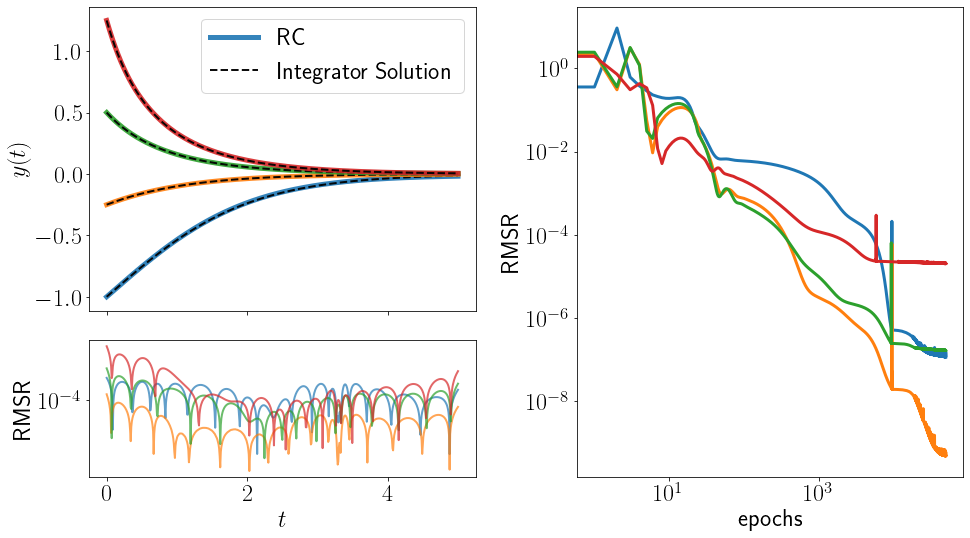

In [26]:
#show results:
fig = plt.figure(figsize = (14,8)); gs1 = gridspec.GridSpec(3, 3);
gs1 = gridspec.GridSpec(3, 6)
horiz_boundary = -3
vert_boundary = -1

g1, g2, g3 = gs1[:vert_boundary, :horiz_boundary], gs1[vert_boundary, :horiz_boundary], gs1[:, horiz_boundary:]
ax=plt.subplot(g1)

plot_predictions(RC, hybrid_results, Bernoulli_model, y0s, ax = ax)

ax=plt.subplot(g2)
plot_data = plot_rmsr(RC, 
                      hybrid_results, 
                      force = no_force, 
                      ax = ax)

plt.subplot(g3)
loss_plot(hybrid_results["losses"])
plt.tight_layout()

#### Below backprop only means that we didn't use the linearization approximation for the weights.

In [27]:
hybrid_color = "dodgerblue"
backprop_color = "orangered"
individual_traj_alpha = 0.9

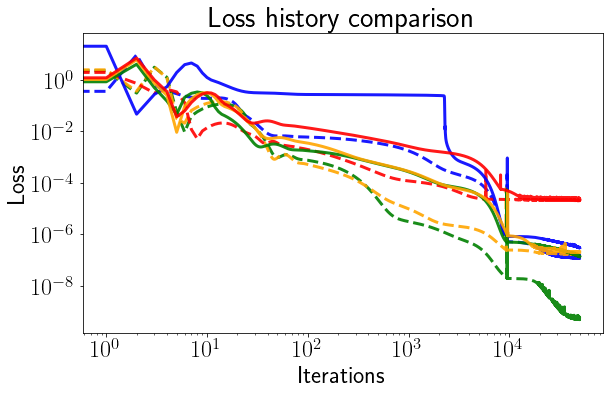

In [28]:
plt.figure(figsize = (9, 6))
plt.title("Loss history comparison")

clr = ['blue', 'green', 'orange','red']

for i, hybrid_loss_i in enumerate(hybrid_results["losses"]):
    hybrid_loss_i = torch.tensor(hybrid_loss_i)
    plt.loglog(hybrid_loss_i, '--', color = clr[i],
               linewidth = lineW, alpha = individual_traj_alpha )
for i, backprop_loss_i in enumerate(backprop_results["losses"]):
    plt.loglog(backprop_loss_i, color = clr[i],
               linewidth = lineW, alpha = individual_traj_alpha )
plt.xlabel("Iterations")
plt.ylabel("Loss")

plt.tight_layout()

In [29]:
final_hs = [min(loss) for loss in hybrid_results["losses"]]
final_bs = [min(loss) for loss in backprop_results["losses"]]


In [30]:
print("Difference between backprop_loss and hybrid_loss")
[final_bs[i] - final_hs[i] for i in range(len(final_bs))]

Difference between backprop_loss and hybrid_loss


[1.835800063076931e-07,
 1.329790158544064e-07,
 3.704771245338634e-08,
 1.4706656656926498e-06]

In [31]:
end_time = time.time()
print(f'Total notebook runtime: {end_time - start_time:.2f} seconds')

Total notebook runtime: 241.32 seconds
